## Random forest for SRQ prediction with more feature engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import warnings
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/augmented_SRQ_data_v2.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12560 entries, 0 to 12559
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           12560 non-null  int64         
 1   Date                 12560 non-null  datetime64[ns]
 2   Flight               12560 non-null  object        
 3   Destination Airport  12560 non-null  object        
 4   Airline              12560 non-null  object        
 5   Boarded              12560 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 588.9+ KB


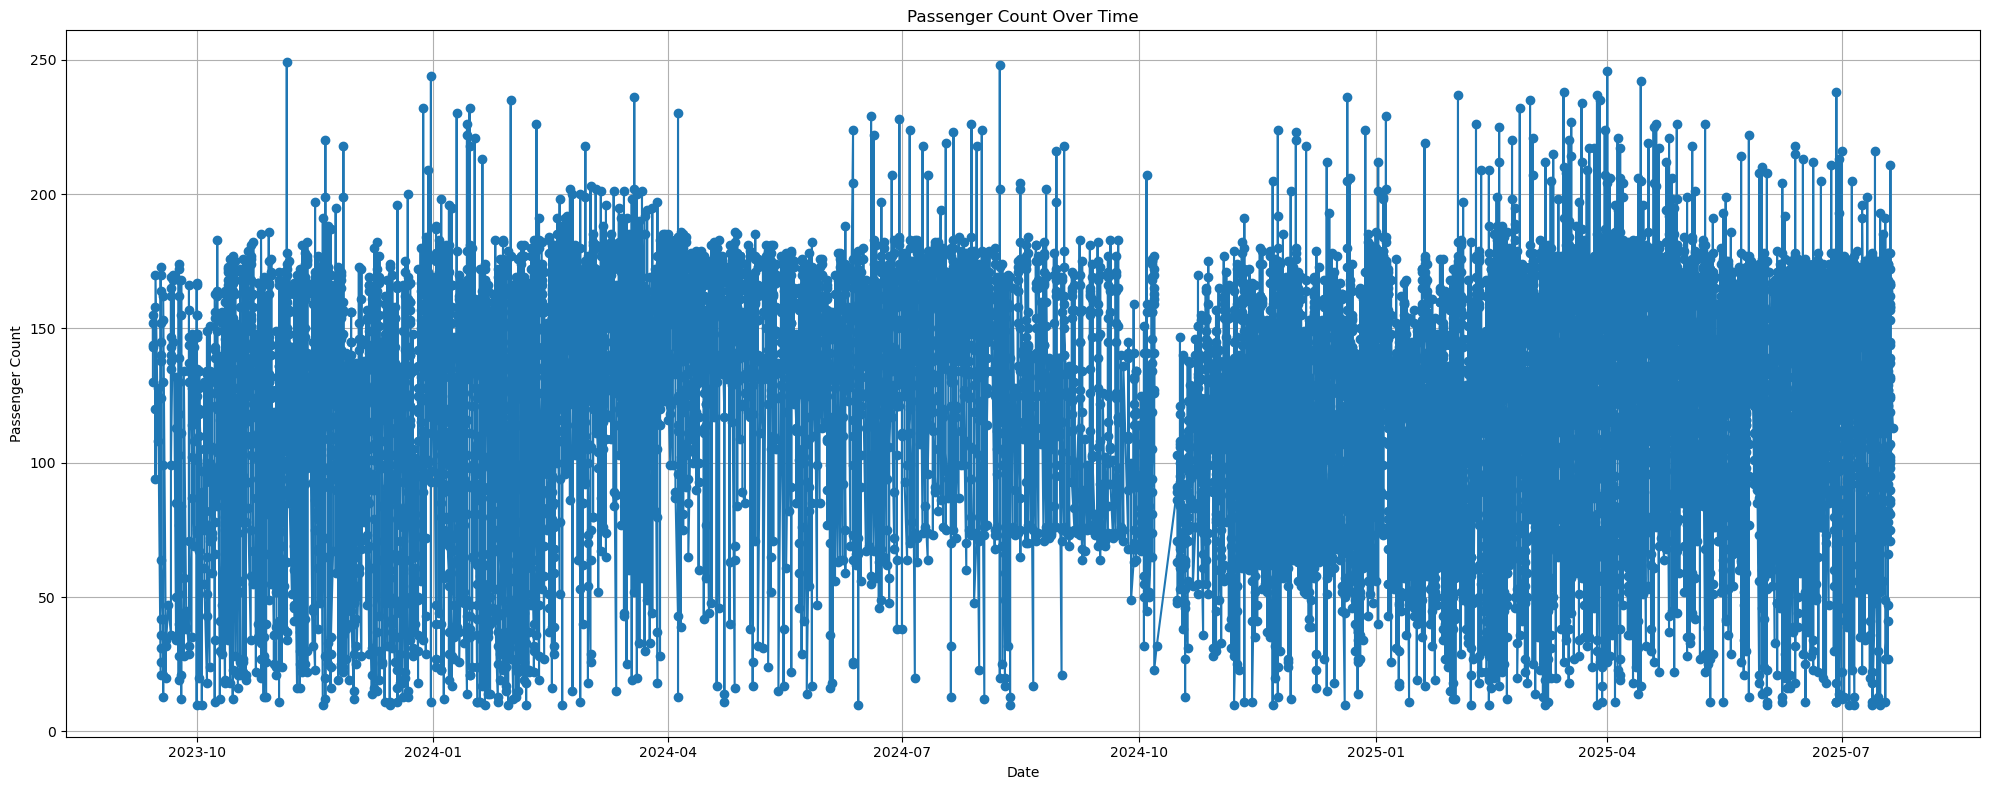

In [3]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables (Try: target encoding instead of categorical)
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0
1,2,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5
2,3,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5
3,4,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5
4,5,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5
...,...,...,...,...,...,...,...,...,...,...,...
12555,13273,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9
12556,13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9
12557,13275,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9
12558,13276,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10


## Cyclical encoding of dates

In [5]:
df['day_sin'] = np.sin(2*np.pi*df['Day_of_Month']/31)
df['day_cos'] = np.cos(2*np.pi*df['Day_of_Month']/31)

# Month (1–12) → convert to 0–11 by subtracting 1, then encode
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Day of Week → if 0=Monday…6=Sunday, just divide by 7
df['dow_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12560 entries, 0 to 12559
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   12560 non-null  int64         
 1   Date                         12560 non-null  datetime64[ns]
 2   Flight                       12560 non-null  object        
 3   Destination Airport          12560 non-null  object        
 4   Airline                      12560 non-null  object        
 5   Boarded                      12560 non-null  int64         
 6   Day_of_Week                  12560 non-null  int32         
 7   Month                        12560 non-null  int32         
 8   Day_of_Month                 12560 non-null  int32         
 9   Destination Airport_encoded  12560 non-null  int32         
 10  Airline_encoded              12560 non-null  int32         
 11  day_sin                      12560 non-nu

## group by airline and destination

In [6]:
route_stats = df.groupby(['Airline','Destination Airport'])['Boarded'].agg([
    ('route_mean','mean'),
    ('route_median','median'),
    ('route_std','std'),
]).reset_index()
df = df.merge(route_stats, on=['Airline','Destination Airport'], how='left')
df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,96.518750,99.5,51.749150
1,2,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,148.430034,162.0,34.409989
2,3,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,150.730769,157.0,23.763546
3,4,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,126.549550,133.5,33.820457
4,5,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,152.762452,160.0,22.801929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,13273,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,105.357143,111.0,35.060103
12556,13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.400000,122.0,39.266401
12557,13275,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,119.448980,128.0,35.404741
12558,13276,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,121.601604,129.0,37.176401


In [7]:
df1 = df[df.isna().any(axis=1)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 2349 to 12481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   12 non-null     int64         
 1   Date                         12 non-null     datetime64[ns]
 2   Flight                       12 non-null     object        
 3   Destination Airport          12 non-null     object        
 4   Airline                      12 non-null     object        
 5   Boarded                      12 non-null     int64         
 6   Day_of_Week                  12 non-null     int32         
 7   Month                        12 non-null     int32         
 8   Day_of_Month                 12 non-null     int32         
 9   Destination Airport_encoded  12 non-null     int32         
 10  Airline_encoded              12 non-null     int32         
 11  day_sin                      12 non-null     f

In [8]:
# remove cols where passenger cound < 10

In [9]:
# Select features for modeling
feature_columns = [
    'Destination Airport_encoded', 'Airline_encoded',
    #'Day_of_Week', 'Month', #'Day_of_Month',
    'day_sin', 'day_cos', 'month_sin',
    'month_cos', 'dow_sin', 'dow_cos',
    'route_mean','route_median', 'route_std'
]

X = df[feature_columns]
y = df['Boarded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (12560, 8)
Target shape: (12560,)


In [10]:
#Need to drop time stamps for modeling but need the timestamps to present data
df_timestamps = df['Date']

#fill nans
#df['route_std'] = df['route_std'].fillna(0)


split_factor = 0.8
split_index = int(len(df) * split_factor)

train_df = df[:split_index]
test_df = df[split_index:]

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=None
# )

# Extract X and y from train and test sets
X_train = train_df[feature_columns]
y_train = train_df['Boarded']

X_test = test_df[feature_columns]
y_test = test_df['Boarded']


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 10048
Testing set size: 2512
Training target range: 10 to 249
Testing target range: 10 to 238


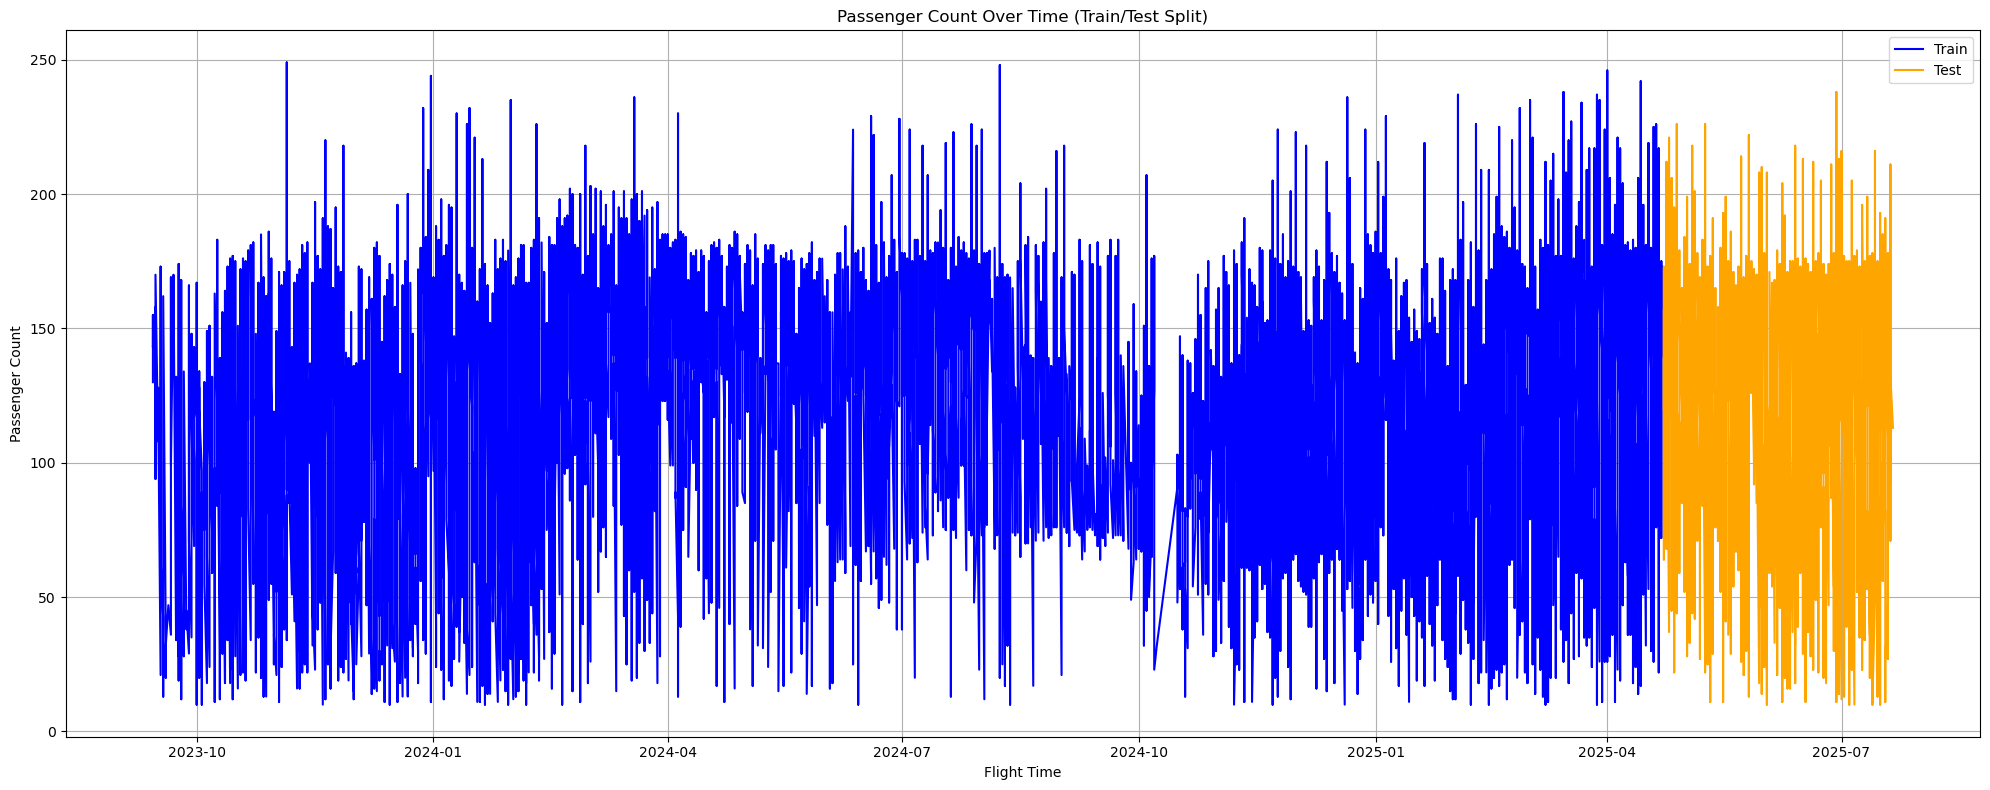

In [11]:
plt.figure(figsize=(20,8))

plt.plot(df_timestamps[:split_index], y_train, label='Train', color='blue')
plt.plot(df_timestamps[split_index:], y_test, label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)')
plt.xlabel('Flight Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
param_grid_random = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion':['squared_error', 'absolute_error', 'poisson']
}

In [13]:
rf = RandomForestRegressor(oob_score=True)
tscv= TimeSeriesSplit(3)

In [14]:
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_random,
    n_iter=1000,  # Number of parameter combinations to try #300
    cv=tscv,
    scoring='neg_mean_absolute_error',  # Use 'neg_mean_squared_error' for regression
    n_jobs=-1,
    verbose=1,
    random_state=42)

Starting Randomized Search...


In [15]:
# 1) Count of NaNs per column
nan_counts = df.isnull().sum()
print("Missing values per column:\n", nan_counts)

Missing values per column:
 Unnamed: 0                      0
Date                            0
Flight                          0
Destination Airport             0
Airline                         0
Boarded                         0
Day_of_Week                     0
Month                           0
Day_of_Month                    0
Destination Airport_encoded     0
Airline_encoded                 0
day_sin                         0
day_cos                         0
month_sin                       0
month_cos                       0
dow_sin                         0
dow_cos                         0
route_mean                      0
route_median                    0
route_std                      12
dtype: int64


In [16]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(oob_score=True), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [17]:
# Get the best model
best_rf = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Make predictions
y_pred = best_rf.predict(X_test)

Best parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'squared_error', 'bootstrap': True}
Best cross-validation score: -28.4207


In [18]:
def predict_passengers(model, flight_time, dest_airport, airline,
                       label_encoders, route_stats, feature_columns):
    # 1) Build base DataFrame
    sample = pd.DataFrame({'Flight Time': [flight_time]})
    
    # 2) Extract raw time features
    dt = pd.to_datetime(sample['Flight Time'])
    sample['Day_of_Month']  = dt.dt.day
    sample['Month']         = dt.dt.month
    sample['Day_of_Week']   = dt.dt.dayofweek  # 0=Mon … 6=Sun
    
    # 3) Cyclical encodings
    sample['day_sin']   = np.sin(2 * np.pi * sample['Day_of_Month'] / 31)
    sample['day_cos']   = np.cos(2 * np.pi * sample['Day_of_Month'] / 31)
    sample['month_sin'] = np.sin(2 * np.pi * (sample['Month'] - 1) / 12)
    sample['month_cos'] = np.cos(2 * np.pi * (sample['Month'] - 1) / 12)
    sample['dow_sin']   = np.sin(2 * np.pi * sample['Day_of_Week'] / 7)
    sample['dow_cos']   = np.cos(2 * np.pi * sample['Day_of_Week'] / 7)
    
    # 4) Categorical encodings
    try:
        sample['Destination Airport_encoded'] = label_encoders['Destination Airport']\
            .transform([dest_airport])[0]
        sample['Airline_encoded'] = label_encoders['Airline']\
            .transform([airline])[0]
    except KeyError as e:
        return f"Error: Missing encoder for {e}"
    except ValueError as e:
        return f"Error: Unknown category - {e}"
    
    # 5) Lookup route statistics
    #    We assume route_stats index on ['Airline','Destination Airport']
    key = (airline, dest_airport)
    try:
        stats = route_stats.set_index(['Airline','Destination Airport'])\
                          .loc[key, ['route_mean','route_median','route_std']]
        sample['route_mean']   = stats['route_mean']
        sample['route_median'] = stats['route_median']
        sample['route_std']    = stats['route_std']
    except KeyError:
        # fallback if this route never seen in training
        sample['route_mean']   = route_stats['route_mean'].mean()
        sample['route_median'] = route_stats['route_median'].median()
        sample['route_std']    = route_stats['route_std'].mean()
    
    # 6) Select features and predict
    try:
        X_sample = sample[feature_columns]
        pred = model.predict(X_sample)[0]
        return int(round(pred))
    except Exception as e:
        return f"Error during prediction: {e}"


In [19]:
# Example usage
example_prediction = predict_passengers(
    best_rf,
    flight_time="2025-07-22 14:38:00",
    dest_airport="DFW",
    airline="AA",
    label_encoders=label_encoders,
    route_stats=route_stats,
    feature_columns=feature_columns
)
    
print(f"Predicted passenger count: {example_prediction}")

Predicted passenger count: 106


In [20]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 968.9088
Root Mean Squared Error: 31.1273
Mean Absolute Error: 23.9851
Mean Absolute Percentage Error: 0.3068
R-squared Score: 0.3489

For context:
Average passenger count: 126.8
Typical prediction error: ±31.1 passengers


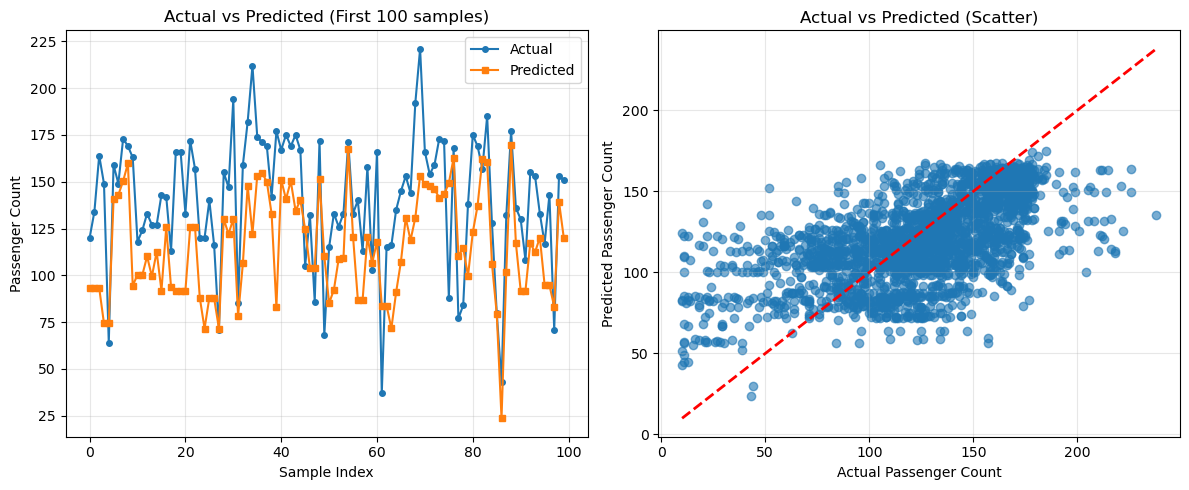

In [21]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(y_pred[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                       feature  importance
5                   route_mean    0.292645
6                 route_median    0.283575
2                    month_cos    0.125925
1              Airline_encoded    0.105921
7                    route_std    0.068425
4                      dow_cos    0.048108
3                      dow_sin    0.042636
0  Destination Airport_encoded    0.032764


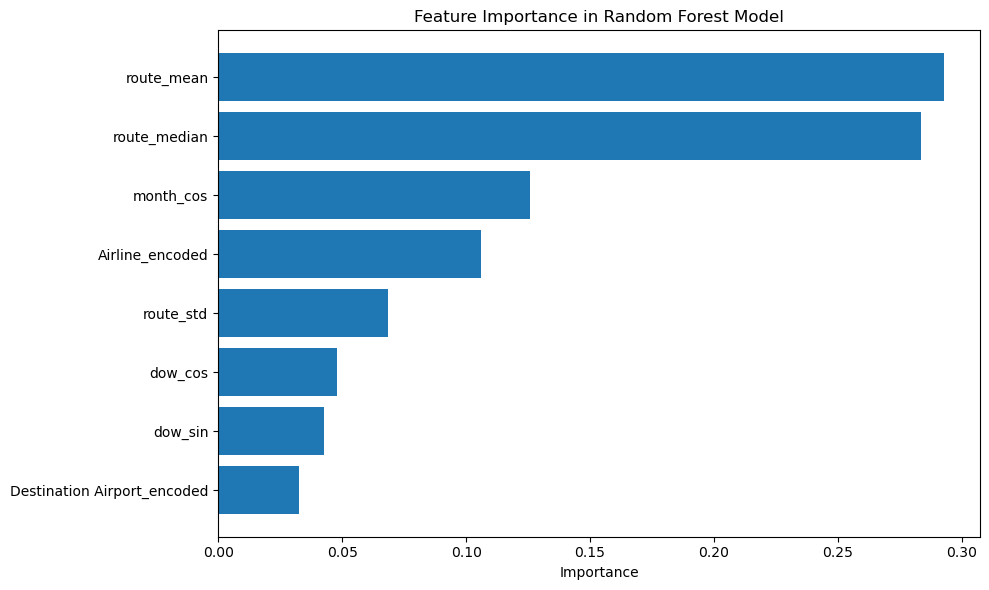

In [22]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
print(df[df['Boarded'] > 300])


Empty DataFrame
Columns: [Unnamed: 0, Date, Flight, Destination Airport, Airline, Boarded, Day_of_Week, Month, Day_of_Month, Destination Airport_encoded, Airline_encoded, day_sin, day_cos, month_sin, month_cos, dow_sin, dow_cos, route_mean, route_median, route_std]
Index: []
